Ich möchte hier in eine tiefere Analyse der vorhandenen Daten der SGC-K-Sensoren einsteigen und konkrete Ergebnisse für die Data Story erarbeiten. Wir werden uns auf Temperatur fokussieren.
!) Wir wissen die Sensoren haben zu unterschiedlichen Zeitpunkten Aufnahmen gemacht. Wir wissen dass sie alle einen Rhytmus von um die 15 Minuten anpeilen, aber nicht verlässlich im Takt die Messungen gemacht haben. Es gab einige Batterieprobleme sodass von den 12 Sensoren 5 seit Dezember bis heute ausgeschaltet sind. Wir haben kein 100%iges Vertrauen in die Datenmessungen und müssen uns die Ausreißer genau anschauen. 

Daraus folgt:


1) Wir müssen uns auf eine Vergleichszeit einigen. Ich hatte bis jetzt 15 Minuten Zeitfenster. Wobei im Fall der Fälle, dass es mehrere Aufnahmen innerhalb eines Fensters gab diese gemittelt wurden. Zeitfenster ohne Wert wurden verworfen. Ich werde zunächst diese Zeitfenstergröße auf 60 Minuten erhöhen und die Werte mitteln. 
2) Wir müssen zunächst die Ausreisser kontrollieren: die Temperaturdifferenzen innerhalb einer Vergleichszeit zwischen den verschiedenen Sensorstationen. ODER die Temperaturdifferenzen entlang der Zeitreihe von Messungen pro Sensorstation (nur da muss man die Lücken in der Zeitreihe im Auge behalten)
3) Vergleiche ziehen zwischen den Sensorstationen aufgeteilt nach Jahreszeit. (Im Winter fehlen überdurchschnittlich viele Werte - das muss bedacht sein.)

Ergebnisse: Eine normierte Vergleichszeit - Temperaturdifferenzen zwischen Stationen zu gleichen Vergleichszeiten 

In [15]:
#Variablen und Ordnerpfad
# imports
import pandas as pd
import matplotlib.pyplot as plt

# CSV Datei einlesen
filepath = "/Users/richie/Projects/SGC-K/data/data_weather_stations_2024.csv"
df_K = pd.read_csv(filepath)

#wichtige Variablen setzen
df_edit = df_K[['name','dateobserved','temperature']].copy()
# change timestamps to timezone-naive values (utc as argument since some entries have ms and somes dont) 
# From entries with +01 and +02 the hours are subtracted respectively
df_edit['dateobserved'] = pd.to_datetime(df_edit['dateobserved'],utc=True, format='ISO8601').dt.tz_convert(None)
df_edit['date'] = df_edit['dateobserved'].dt.date
df_edit['time'] = df_edit['dateobserved'].dt.time
df_edit['hour'] = df_edit['dateobserved'].dt.hour
df_edit['week_of_year'] = df_edit['dateobserved'].dt.isocalendar().week

#df_edit['entity_id'] = df_edit['entity_id'].str.replace("urn:ngsi-ld:WeatherObserved:", "", regex=True)

In [19]:
#1 Vergleichszeit 
df_edit.head()

# Set the dateobserved-column as index
df_edit.set_index("dateobserved", inplace=True)
# group by name and resample the index to 60 minutes
df_edit = df_edit.groupby('name').resample('60min').mean(numeric_only=True).reset_index()



print("NaNs after resampling:", df_edit.isna().sum().sum()) # I have 3475 rows with NAN values
print(df_edit.isna().sum())

# drop all rows with NAN Values
df_valid = df_edit.dropna()


NaNs after resampling: 10425
name               0
dateobserved       0
temperature     3475
hour            3475
week_of_year    3475
dtype: int64


In [20]:
"""
Ich möchte ein Diagramm, das die Zeitachse aller Werte in df_valid vom frühesten bis zum spätesten Wert zeigt, und ich möchte 
fehlende 60-Minuten-Slots in rot und die vorhandenen in grün  kodieren.
"""
# Sicherstellen, dass 'dateobserved' datetime ist
df_valid["dateobserved"] = pd.to_datetime(df_valid["dateobserved"])

# Stationen bestimmen
stations = df_valid["name"].unique()
num_stations = len(stations) 

# vollständige Liste aller Zeitstempel von allen Stationen berechnen
earliest_day = df_valid["dateobserved"].min()
latest_day = df_valid["dateobserved"].max()
full_range = pd.date_range(start=earliest_day, end=latest_day, freq="H")

# Dictionary zur Speicherung der vorhandenen Zeitstempel pro Station 
station_timestamps = {}
for station in stations:
    #nur Zeilen mit der aktuellen station auswählen
    station_data = df_valid[df_valid["name"] == station]
    #station_data["dateobserved"] enthält die Zeitstempel (dateobserved) für diese Station, als set
    # umwandeln und in das Dictionary speichern ( Schlüssel: name, Wert: Set an Timestamps)
    station_timestamps[station] = set(station_data["dateobserved"])


# Schnittmenge der vorhandenen Zeitstempel für ALLE Stationen
common_timestamps = set(full_range)
# Intersection (nur Zeiten behalten, die überall vorkommen mit &=)
# timestamps ist die Menge aller Zeitstempel für eine einzelne Station
for timestamps in station_timestamps.values():
    # &= -> Behaltet nur die Zeitstempel, die in beiden Mengen existieren
    common_timestamps &= timestamps  

print(len(common_timestamps)) #3757 Zeitstempel wo alle Stationen Werte haben


3757


/var/folders/k5/njyjkt_x2mg0jkrvd3g_wnhc0000gn/T/ipykernel_6808/1268636578.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid["dateobserved"] = pd.to_datetime(df_valid["dateobserved"])
/var/folders/k5/njyjkt_x2mg0jkrvd3g_wnhc0000gn/T/ipykernel_6808/1268636578.py:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_range = pd.date_range(start=earliest_day, end=latest_day, freq="H")


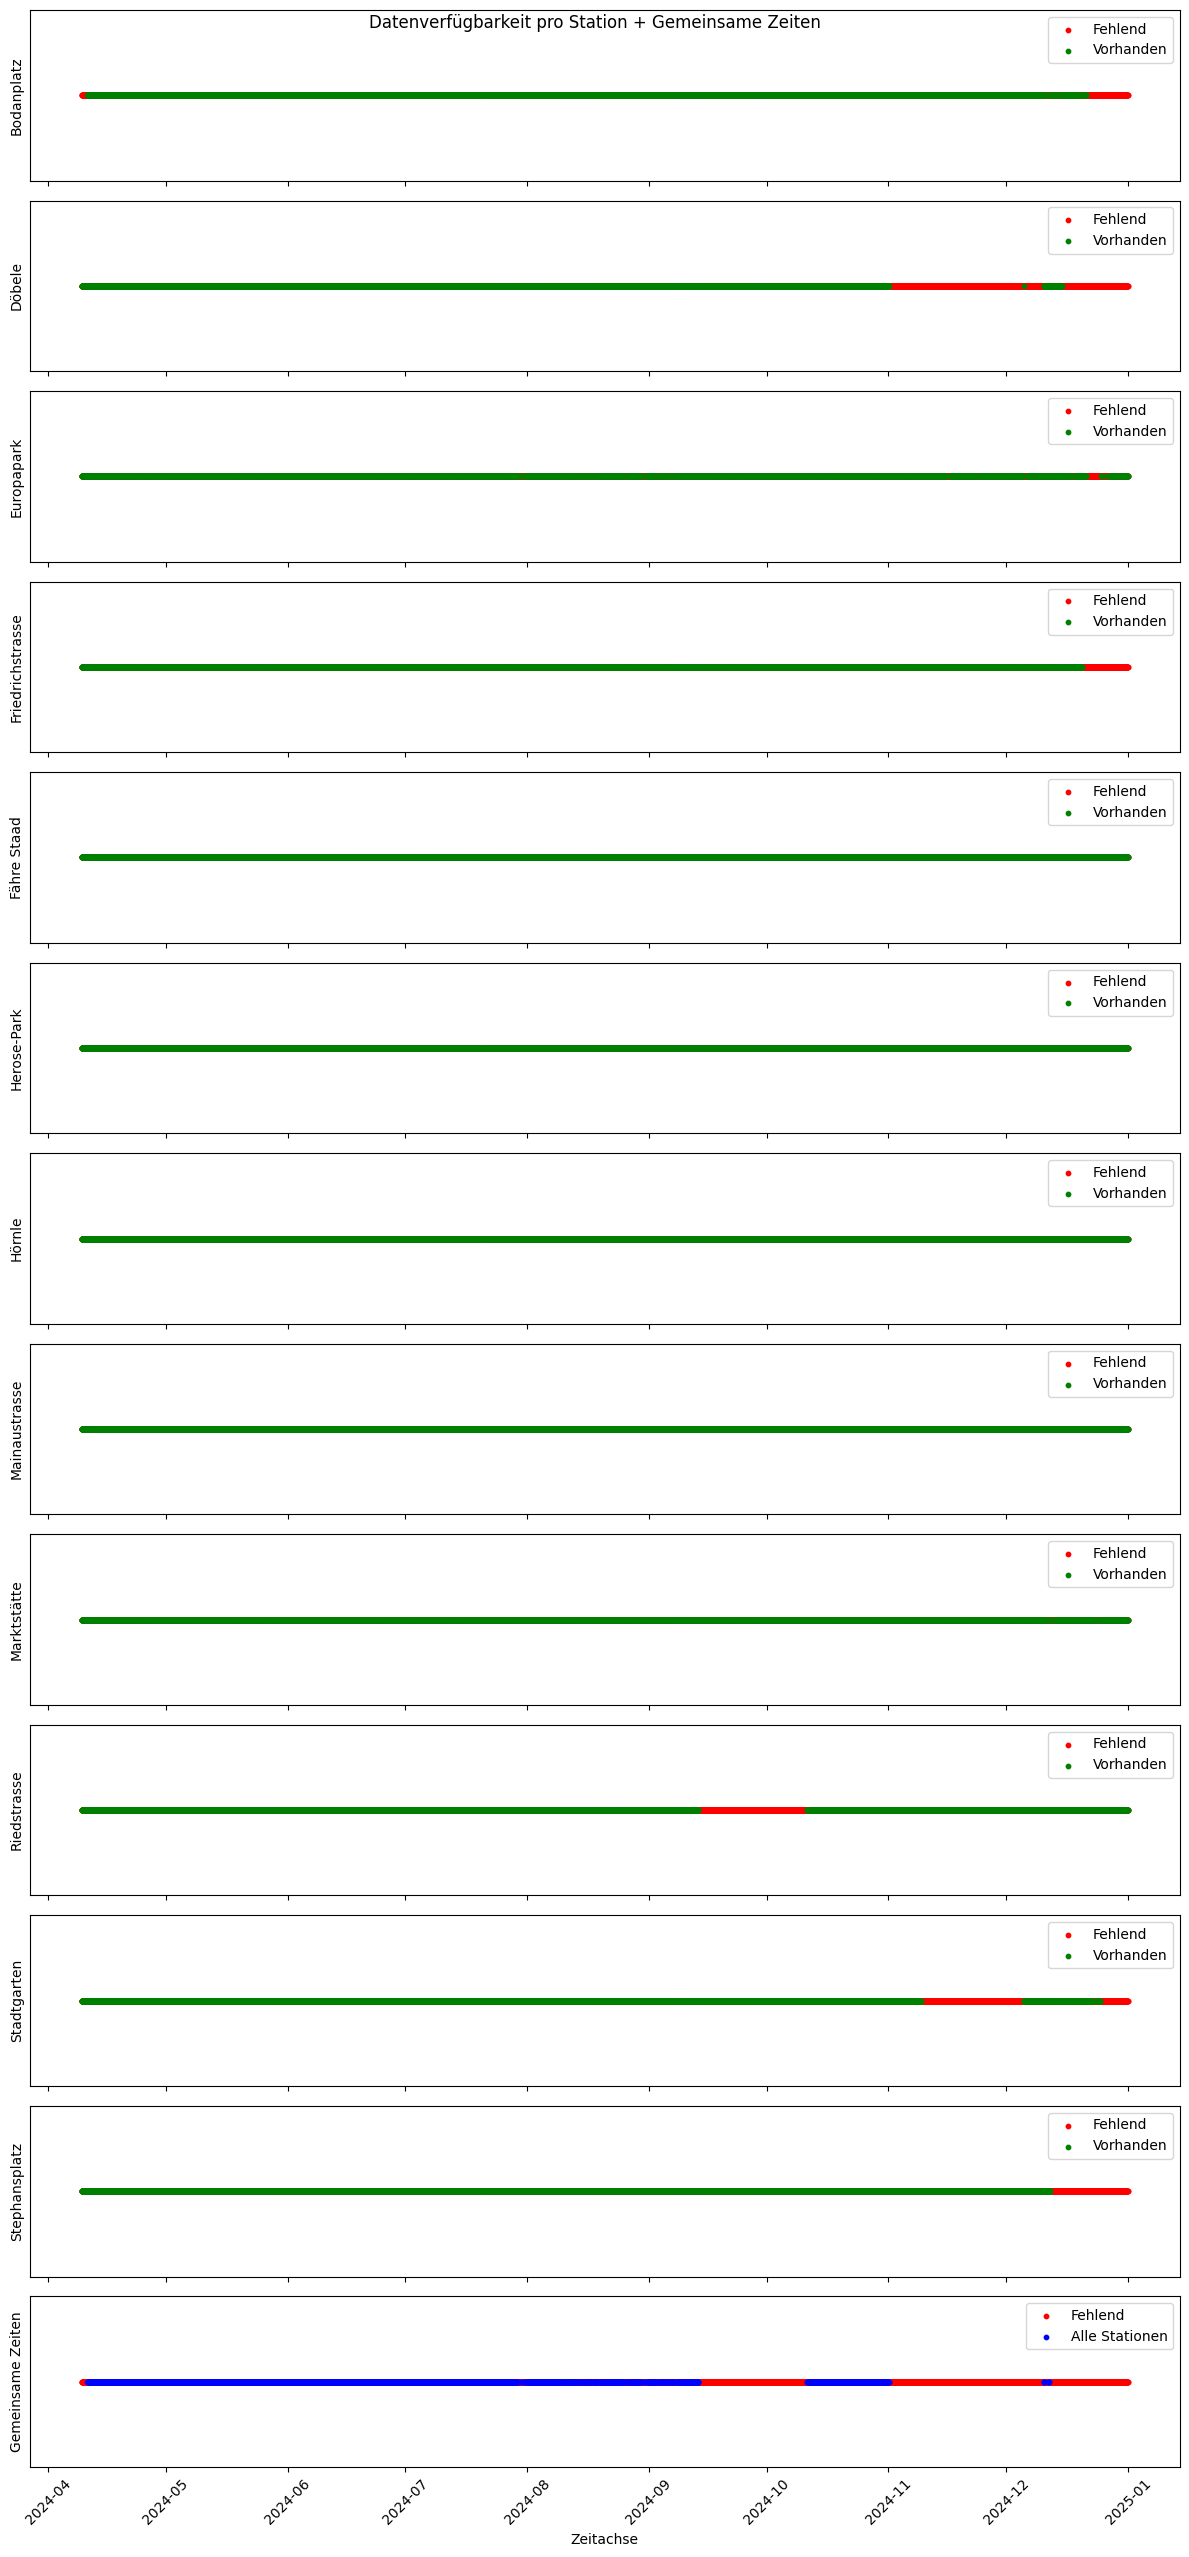

In [21]:
# Figure erstellen
# axes ist eine Liste von Subplots
fig, axes = plt.subplots(num_stations + 1, 1, figsize=(12, 2 * (num_stations + 1)), sharex=True)

# Plot für jede Station: 
# die Punkte für fehlende (rot) und vorhandene (grün) Zeitstempel werden 
# übereinander auf derselben Achse geplottet

for ax, station in zip(axes[:-1], stations):
    #Die Funktion zip() wird hier benutzt, um jeweils eine Achse (ax) mit einer 
    #Station (station) zu kombinieren.
    existing_timestamps = station_timestamps[station]
    missing_timestamps = [ts for ts in full_range if ts not in existing_timestamps]

    ax.scatter(full_range, [1] * len(full_range), color='red', s=10, label="Fehlend")
    ax.scatter(list(existing_timestamps), [1] * len(existing_timestamps), color='green', s=10, label="Vorhanden")

    ax.set_yticks([])  # Y-Achse ausblenden
    ax.set_ylabel(station)  # Stationsnamen als Label
    ax.legend(loc="upper right")

# Letzte Zeile: Gemeinsame Zeiten
ax_common = axes[-1]
ax_common.scatter(full_range, [1] * len(full_range), color='red', s=10, label="Fehlend")
ax_common.scatter(list(common_timestamps), [1] * len(common_timestamps), color='blue', s=10, label="Alle Stationen")


ax_common.set_yticks([])
ax_common.set_ylabel("Gemeinsame Zeiten")
ax_common.legend(loc="upper right")

# X-Achse formatieren
plt.xticks(rotation=45)
axes[-1].set_xlabel("Zeitachse")
plt.suptitle("Datenverfügbarkeit pro Station + Gemeinsame Zeiten")
plt.tight_layout()
plt.show()

Einordnung der verschiedenen Standorte:
eher städtisch: 
- Stephansplatz (nicht aktuell)
- Marktstätte (aktuell)
- Bodanplatz (nicht aktuell)
- Friedrichstraße (nicht aktuell)

eher im Grünen:
- Europapark (aktuell)
- Riedstraße (Industriegebiet, aktuell)
- Herose-Park (aktuell)
- Mainaustraße (an einer großen straße aber an einer großen Wiese, aktuell)
  
am See: 
- Stadtgarten (nicht aktuell)
- Fähre Staad (aktuell)
- Hörnle (aktuell)

Nicht eingetragen: 
- Döbele

Ich habe meine Temperaturdaten für die einzelnen Standorte. Ich habe auf der Karte gesehen dass die Standorte eingeteilt werden können in "eher städtischer Standort" vs. "eher im Grünen" vs. "direkt am See" 
Ich habe pro Kategorie 3 Standorte manuell zuordnen können. 
Ich frage mich ob ich diese manuelle Kategorien auch aus den aufgenommenen Temperaturdaten lesen kann.

1) Als erstes werde ich pro Standort wichtige Merkmale berechenen zB Temperaturmittelwert, Spannweite, Schwankungen (Standardabweichungen)
2) Dann werde ich versuchen eine K-means-Cluster-Analyse durchzuführen um zu schauen ob Temperaturverläufe wirklich standortspezifische Muster haben (z. B. am See geringere Schwankungen, in der Stadt höhere Durchschnittstemperaturen, etc.)

In [81]:
#Herausfinden welche Stationen geeignet sind:

Anzahl_Messungen = len(df_valid['dateobserved'])
Anzahl_Stationen = df_valid['name'].unique()
#print(Anzahl_Stationen)
#print(Anzahl_Messungen) # 71.628 Stündliche Messungen insgesamt

"""
Wir wissen schon dass wir unterschiedliche Anzahlen an Messungen pro Station haben.
"""
measurements = df_valid["name"].value_counts() # Unterschiedliche Anzahlen an Messungen pro Station
#print(measurements)
#ax = measurements.plot.bar(x='Standort Messgerät', y='Anzahl Messungen', rot=90)
"""
Also wichtig: Zeitpunkte herauszufiltern an denen eine Mindestanzahl an Stationen Messungen gemacht haben.
"""
num_all_stations = 12
num_min_stations = 8 # weil 4 seit Dezember aus sind 

# Zähle, wie viele Stationen pro Stunde Messungen gemacht haben
stations_per_hour = df_valid.groupby('dateobserved')['name'].nunique()

# Filtere Stunden, in denen die Mindestanzahl der Stationen Messungen gemacht haben
valid_hours_min_stations = stations_per_hour[stations_per_hour >= num_min_stations].index

# Filtere Stunden, in denen die Mindestanzahl der Stationen Messungen gemacht haben
valid_hours_all_stations = stations_per_hour[stations_per_hour >= num_all_stations].index

# Filtere das DataFrame, um nur diese Stunden zu behalten
df_all_stations = df_valid[df_valid['dateobserved'].isin(valid_hours_all_stations)]
df_multiple_stations = df_valid[df_valid['dateobserved'].isin(valid_hours_min_stations)]


In [88]:
df_all_stations.columns
w = df_all_stations.copy()
w['date'] = w['dateobserved'].dt.date
w.columns

# gruppieren pro Tag 
temp_per_day = w.groupby('date')['name']
temp_per_day

In [90]:
df_all_stations['date'].head()

0     2024-04-10
7     2024-04-11
10    2024-04-11
11    2024-04-11
12    2024-04-11
Name: date, dtype: object

In [108]:
# Jetzt entnehme ich Tage aus dem df_all_stations zunächst für Sommer (Juli,August)
# https://www.dwd.de/DE/leistungen/deutscherklimaatlas/erlaeuterungen/elemente/_functions/faqkarussel/sommertage.html
# Maximum mindestens 25 grad (??) 

# Beispielmonat Juli 
# Filter data between two dates
startdate_july = pd.to_datetime("2024-06-30").date()
enddate_july = pd.to_datetime("2024-08-01").date()
july_df = df_all_stations.loc[(df_all_stations['date'] >= startdate_july)
                     & (df_all_stations['date'] < enddate_july)]

#july_df # 8544 Einträge im Juli ( Einträge = wo mindestens 12 Messungen pro Stunde existieren, ergo 712 Messstunden)

# Beispielmonat August
# Filter data between two dates
startdate_august = pd.to_datetime("2024-07-31").date()
enddate_august = pd.to_datetime("2024-09-01").date()
august_df = df_all_stations.loc[(df_all_stations['date'] >= startdate_august)
                     & (df_all_stations['date'] < enddate_august)]

#august_df # 5712 Einträge im August ( == 476 vollen Messstunden) 



In [117]:
import numpy as np
import pandas as pd

# Beispielhafte Pivot-Tabelle (july_df sollte deine Datensätze enthalten)
pivot_df = july_df.pivot_table(index='date', columns='name', values='temperature')

# Berechne für jedes Datum die Temperaturdifferenzen zwischen allen Stationen
# Wir erstellen eine neue Matrix der Differenzen zwischen allen Stationspaaren

# Leere Liste für die maximalen Differenzen
max_diffs_per_date = []

for index, row in pivot_df.iterrows():
    # Umwandlung der Zeile in ein NumPy-Array
    temperatures = row.values
    # Berechnung der äußeren Differenz zwischen allen Stationen (1D-Array)
    temp_diff_matrix = np.abs(np.subtract.outer(temperatures, temperatures))
    # Maximale Differenz für dieses Datum
    max_diff = temp_diff_matrix[temp_diff_matrix != 0].max()  # Ausschließen der Diagonale (selbst mit sich selbst vergleichen)
    max_diffs_per_date.append((index, max_diff))

# Konvertiere die Ergebnisse in einen DataFrame
max_diffs_df = pd.DataFrame(max_diffs_per_date, columns=['date', 'max_diff'])

# Zeige die maximalen Differenzen an
print(max_diffs_df.head())  # Zeigt die ersten 5 Zeitpunkte mit den höchsten Differenzen an


         date  max_diff
0  2024-06-30  1.093472
1  2024-07-01  1.350819
2  2024-07-02  0.992649
3  2024-07-03  0.822299
4  2024-07-04  1.519479


In [121]:
# höchsten Temperaturdifferenzen im Monat Juli:

# Pivotieren der Daten, sodass jede Station eine Spalte hat und die Zeitpunkte als Zeilen
pivot_july_df = july_df.pivot_table(index='dateobserved', columns='name', values='temperature')

# Berechne die Temperaturdifferenzen zwischen allen Standorten für jeden Zeitpunkt
# Wir nehmen die maximale Differenz zwischen den Stationen für jeden Zeitpunkt
max_temp_july = pivot_july_df.max(axis=1)  # Maximaler Temperaturwert
min_temp_july = pivot_july_df.min(axis=1)  # Minimaler Temperaturwert
temp_diff_july = max_temp_july - min_temp_july  # Temperaturdifferenz

# Finde die Top 10 Zeitpunkte mit den größten Temperaturdifferenzen
top_10_diff_july = temp_diff_july.nlargest(10)

# Jetzt auch die Stationen, die diese Maxima und Minima repräsentieren
top_10_station_combinations_july = pd.DataFrame({
    'max_temp_station': pivot_july_df.idxmax(axis=1),
    'min_temp_station': pivot_july_df.idxmin(axis=1),
    'temp_diff': temp_diff_july
})

# Filtern der Top 10 Zeitpunkte mit den größten Temperaturdifferenzen
top_10_station_combinations_july = top_10_station_combinations_july.loc[top_10_diff_july.index]

# Ausgabe der Top 10 Zeitpunkte und Stationen mit den größten Temperaturdifferenzen
print(top_10_station_combinations_july)


# im Monat August

# Pivotieren der Daten, sodass jede Station eine Spalte hat und die Zeitpunkte als Zeilen
pivot_august_df = august_df.pivot_table(index='dateobserved', columns='name', values='temperature')

# Berechne die Temperaturdifferenzen zwischen allen Standorten für jeden Zeitpunkt
max_temp_august = pivot_august_df.max(axis=1)  # Maximaler Temperaturwert
min_temp_august = pivot_august_df.min(axis=1)  # Minimaler Temperaturwert
temp_diff_august = max_temp_august - min_temp_august  # Temperaturdifferenz

# Finde die Top 10 Zeitpunkte mit den größten Temperaturdifferenzen
top_10_diff_august = temp_diff_august.nlargest(10)

# Jetzt auch die Stationen, die diese Maxima und Minima repräsentieren
top_10_station_combinations_august = pd.DataFrame({
    'max_temp_station': pivot_august_df.idxmax(axis=1),
    'min_temp_station': pivot_august_df.idxmin(axis=1),
    'temp_diff': temp_diff_august
})

# Filtern der Top 10 Zeitpunkte mit den größten Temperaturdifferenzen
top_10_station_combinations_august = top_10_station_combinations_august.loc[top_10_diff_august.index]

# Ausgabe der Top 10 Zeitpunkte und Stationen mit den größten Temperaturdifferenzen
print(top_10_station_combinations_august)

# Jetzt noch checken ob mit Riedstraße und Stadtgarten alles in ordnung ist von den Messungen her - oder ob die vertrauenswürdig aussehen
# was noch interessant seien könnte wäre diese Spitzentage noch genauer anzuschauen, wie schnell ist es an den tagen um die Abendstunden kühler gewordne
# an dem einen vs. dem anderen Standort? 

                    max_temp_station min_temp_station  temp_diff
dateobserved                                                    
2024-07-27 14:00:00      Riedstrasse      Stadtgarten   6.119500
2024-07-31 11:00:00      Riedstrasse      Stadtgarten   5.724444
2024-07-27 13:00:00      Riedstrasse      Stadtgarten   5.606643
2024-07-20 15:00:00    Stephansplatz      Stadtgarten   5.475250
2024-07-27 12:00:00      Riedstrasse      Stadtgarten   5.462804
2024-07-26 13:00:00      Riedstrasse      Stadtgarten   5.308583
2024-07-09 17:00:00    Stephansplatz           Hörnle   5.100000
2024-07-05 15:00:00      Riedstrasse      Stadtgarten   5.100000
2024-07-05 12:00:00      Riedstrasse      Stadtgarten   5.020336
2024-07-26 14:00:00      Riedstrasse      Stadtgarten   5.000000
                    max_temp_station min_temp_station  temp_diff
dateobserved                                                    
2024-08-29 14:00:00      Riedstrasse      Stadtgarten   6.400250
2024-08-12 15:00:00      

In [104]:
# Bokeh Plot of July
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import HoverTool, ColumnDataSource, DatetimeTickFormatter
from bokeh.palettes import Paired12

stations = df_all_stations["name"].unique()

q = july_df.copy() 
q.index = pd.to_datetime(q["dateobserved"], format='ISO8601', utc=True)

# Create Bokeh plot with multiple lines (one per station)
p = figure(x_axis_type="datetime", title="Temperaturverlauf pro Station im Juli 2024", width=1200, height=600)
p.xaxis.axis_label = "Datum"
p.yaxis.axis_label = "Temperatur (°C)"

# Assign distinct colors to stations
colors = ["blue", "red", "green", "purple", "orange", "brown", "pink", "cyan"]
station_colors = dict(zip(stations, Paired12))

# Add lines for each station
for station in stations:
    station_data = q[q["name"] == station]
    source = ColumnDataSource(data=dict(
        x=station_data.index,
        y=station_data["temperature"],
        #name=df["name"] * len(station_data)
    ))
    
    p.line('x', 'y', source=source, line_width=2, legend_label=station, color=station_colors[station])
    p.scatter('x', 'y', source=source, size=5, color=station_colors[station], legend_label=station)

# Configure legend
p.legend.title = "Stationen"
p.legend.location = "top_right"
p.legend.click_policy = "hide"  # Allow hiding of individual lines

# Add hover tool for better interaction
hover = HoverTool(
    tooltips=[("Temperatur", "@y")]
)
p.add_tools(hover)

p.y_scale

# Adjust the datetime formatting on the x-axis to show month and year properly
p.xaxis.formatter = DatetimeTickFormatter(
    minutes="%Y-%m-%d %H:%M",
    hours="%Y-%m-%d %H:%M",
    days="%Y-%m-%d",
    months="%Y-%m",
    years="%Y"
)

p.y_range.end = 40

# Show the plot
show(p)


In [71]:
# Berechnungen der Statistiken in dem Dataframe in denen nur Zeitpunkte sind in denen alle Stationen aufnahmen gemacht haben

stats_all = df_all_stations.groupby('name')['temperature'].agg(
    mean_temp = 'mean', # Mittelwert
    temp_range = lambda x: x.max() - x.min(), # Spannweite
    std_temp = 'std' # Standardabweichung
).reset_index()

stats_orig = df_valid.groupby('name')['temperature'].agg(
    mean_temp = 'mean', # Mittelwert
    temp_range = lambda x: x.max() - x.min(), # Spannweite
    std_temp = 'std' # Standardabweichung
).reset_index()

# Merge der beiden DataFrames (stats_all und stats_orig) basierend auf dem 'name'
stats_diff = pd.merge(stats_all, stats_orig, on='name', suffixes=('_all', '_orig'))

# Berechne die Differenzen der Statistiken
stats_diff['mean_diff'] = stats_diff['mean_temp_all'] - stats_diff['mean_temp_orig']
stats_diff['range_diff'] = stats_diff['temp_range_all'] - stats_diff['temp_range_orig']
stats_diff['std_diff'] = stats_diff['std_temp_all'] - stats_diff['std_temp_orig']

# Optional: Ausgabe der ersten Zeilen der Differenzen
print(stats_diff[['name', 'mean_diff', 'range_diff', 'std_diff']])


                name  mean_diff  range_diff  std_diff
0         Bodanplatz   2.029798   -2.924975 -1.158620
1             Döbele   0.335241   -1.350000 -0.282977
2         Europapark   2.969114   -4.833308 -1.248871
3   Friedrichstrasse   2.269327   -2.749950 -1.220008
4        Fähre Staad   2.729970   -4.150000 -1.626238
5        Herose-Park   2.665002   -4.550000 -1.601667
6             Hörnle   2.766623   -4.550000 -1.632214
7      Mainaustrasse   2.870176   -4.449975 -1.636012
8        Marktstätte   2.629831   -4.674975 -1.580257
9        Riedstrasse   2.908879   -5.649975 -1.906175
10       Stadtgarten   1.170694   -1.449975 -0.736322
11     Stephansplatz   1.919121   -2.924975 -1.032846


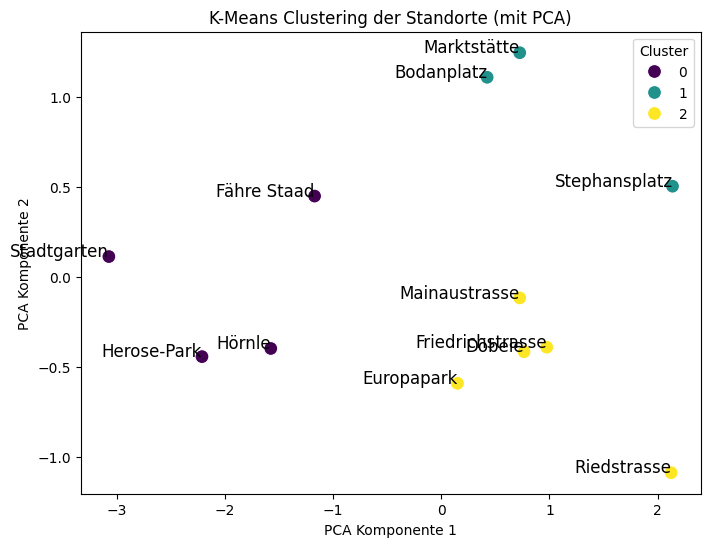

                name  mean_temp  temp_range  std_temp  cluster
0         Bodanplatz  16.887061   30.575025  5.803839        1
1             Döbele  16.541475   31.666333  5.957207        2
2         Europapark  16.401633   31.100025  5.914689        2
3   Friedrichstrasse  16.580566   31.849800  5.978561        2
4        Fähre Staad  16.459295   29.933333  5.596220        0
5        Herose-Park  16.060402   29.700000  5.503229        0
6             Hörnle  16.175640   29.970833  5.617505        0
7      Mainaustrasse  16.609709   31.700025  5.895064        2
8        Marktstätte  16.965011   31.049525  5.785810        1
9        Riedstrasse  16.579196   33.099525  6.186732        2
10       Stadtgarten  16.078489   28.250025  5.422906        0
11     Stephansplatz  16.988907   32.799775  5.989914        1


In [80]:
"""
Clustering
"""
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 🔹 Daten skalieren (wichtig für K-Means!)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(stats_all[['mean_temp', 'temp_range', 'std_temp']])

# 🔹 K-Means Clustering mit 3 Clustern
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
stats['cluster'] = kmeans.fit_predict(X_scaled)

# 🔹 Visualisierung mit PCA (2D-Projektion)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=stats['cluster'], palette='viridis', s=100)
for i, name in enumerate(stats['name']):
    plt.text(X_pca[i, 0], X_pca[i, 1], name, fontsize=12, ha='right')
plt.title("K-Means Clustering der Standorte (mit PCA)")
plt.xlabel("PCA Komponente 1")
plt.ylabel("PCA Komponente 2")
plt.legend(title="Cluster")
plt.show()

# 🔹 Ausgabe der Cluster-Zuordnung
print(stats)


In [23]:
# Punkt 2: extreme Ausreißer aus den Temperatur-Daten filtern. 
# Methode 1  die Temperaturdifferenzen innerhalb einer Vergleichszeit zwischen den verschiedenen Sensorstationen
#we have a set of time_stamps - df_valid is already grouped by name and dropped all nan rows 
#print(df_valid.head())

# calculate mean of temperature measurements per time slot 
#timeslots = df_valid["dateobserved"].unique()

# Dictionary zur Speicherung der vorhandenen Zeitstempel pro Station 
#common_timestamps
